# Proyecto 1 — Analítica de textos

Integrantes:

* Juan Diego Cardona
* María Camila Terán
* Nicolás Ortega

## 0. Introducción

**Tema: Predicción de emociones acorde a comentarios o posts en redes sociales**

En la actualidad la mayoría de personas se encuentran en las redes sociales y por lo general no son tímidas al comentar o publicar su opinión en estas, lo que las convierte en una fuente de información ilimitada de las opiniones de los usuarios. Dado que el contenido es solo escrito, las palabras usadas hacen mucho énfasis en sus emociones al momento de publicar una opinión. De acuerdo con esto, sería posible entrenar un modelo de clasificación que permita determinar que emoción o emociones tenía el usuario al momento de realizar una publicación.

**Interés de negocio** 

Si se realizan filtraciones referentes a cierto comercio, producto o sector de negocios, sería posible hacerse a una idea de cómo se encuentra la opinión publica al respecto, lo cual puede ser significativamente útil para realizar campañas de marketing y promoción en diversos contextos que funcionen óptimamente.

## 1. Carga de librerías

In [1]:
!pip install imbalanced-learn

In [2]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import string
import re

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modelado
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolasortega/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Perfilamiento y entendimiento de los datos

### 2.1 Carga de los datos

In [3]:
df = pd.read_csv('datos.csv',sep=';',header=None)
df.columns = ['Mensaje','Sentimiento']
df.head(5)

,Mensaje,Sentimiento
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


### 2.2 Entendimiento de los datos

Observamos la descripción general de los datos. En total se observan 2000 registros y solo dos columnas. La primera columna contiene el mensaje (texto) que se analizará y la segunda corresponde al sentimiento (etiqueta) asociado a dicho mensaje. Los datos no presentan registros nulos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Mensaje      2000 non-null   object
 1   Sentimiento  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [5]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Mensaje']]
textos.sample(4)

,Mensaje,Sentimiento,Conteo
1786,im feeling all jolly and warm inside but i jus...,joy,58
56,i had every intention of doing more gardening ...,sadness,115
655,i feel inspired so many thing i want to write ...,joy,50
71,i feel like a naughty school girl because i am...,love,61


In [6]:
textos["Conteo"].describe()

count    2000.000000
mean       96.586500
std        55.715991
min        14.000000
25%        52.000000
50%        86.000000
75%       130.000000
max       296.000000
Name: Conteo, dtype: float64

En la tabla anterior se observa el conteo de caracteres de cada mensaje. Luego, vemos algunas estadísticas descriptivas sobre este. En promedio los mensajes a analizar contienen un promedio de 96 caracteres, y presentan una alta desviación estándar de 55 caracteres. Este comportamiento es entendible teniendo en cuanta que son mensajes que son publicados en redes sociales.

Ahora, para realizar una perfilamiento y análisis más profundo sobre el contenido de los datos, será necesario empezar con las tareas de preprocesamiento, ya que como se encuentran los datos actualmente, no es posible extraer mucha más información. A continuación, se empieza dicho proceso.

## 3. Preprocesamiento de los datos

### 3.1 Limpieza y Tokenización

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Esta tareea se realiza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula. Para este caso, se toma una función encontrada en [un artículo de cienciadedatos.net](https://www.cienciadedatos.net/documentos/py25-text-mining-python.html) que, si bien no está tan optimizada como las de algunas librerías, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado.

In [7]:
def limpiar_tokenizar(mensaje):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = mensaje.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(mensaje=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


Se aplica la función de limpieza y tokenización a cada mensaje


In [8]:
df['mensaje_tokenizado'] = df['Mensaje'].apply(lambda x: limpiar_tokenizar(x))
df[['Mensaje', 'mensaje_tokenizado']].head()

,Mensaje,mensaje_tokenizado
0,im feeling rather rotten so im not very ambiti...,"[im, feeling, rather, rotten, so, im, not, ver..."
1,im updating my blog because i feel shitty,"[im, updating, my, blog, because, feel, shitty]"
2,i never make her separate from me because i do...,"[never, make, her, separate, from, me, because..."
3,i left with my bouquet of red and yellow tulip...,"[left, with, my, bouquet, of, red, and, yellow..."
4,i was feeling a little vain when i did this one,"[was, feeling, little, vain, when, did, this, ..."


### 3.2 Análisis exploratorio

Ahora, realizaremos nuevamente un breve perfilamiento con las transformaciones realizadas en el paso anterior. Se revisará principalmente las palabras que encontramos en nuestra columna de "Mensajes"

In [9]:
# Unnest de la columna texto_tokenizado
df_tidy = df.explode(column='mensaje_tokenizado')
df_tidy = df_tidy.drop(columns='Mensaje')
df_tidy = df_tidy.rename(columns={'mensaje_tokenizado':'token'})
df_tidy.sample(5)

,Sentimiento,token
591,sadness,before
1147,joy,situations
1327,anger,getting
1628,anger,protests
1574,sadness,like


#### 3.2.1 Frecuencia de palabras

In [10]:
# Palabras totales utilizadas por sentimiento
print('--------------------------')
print('Palabras totales por sentimiento')
print('--------------------------')
df_tidy.groupby(by='Sentimiento')['token'].count()

--------------------------
Palabras totales por sentimiento
--------------------------


Sentimiento
anger        4759
fear         3588
joy         11899
love         2851
sadness      9822
surprise     1154
Name: token, dtype: int64

In [11]:
# Palabras distintas utilizadas por cada sentimiento
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
df_tidy.groupby(by='Sentimiento')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


Sentimiento
anger       1299
fear        1050
joy         2493
love         938
sadness     2049
surprise     461
Name: token, dtype: int64

In [12]:
# Palabras distintas
print('----------------------------------')
print('Número total de palabras distintas')
print('----------------------------------')
df_tidy['token'].nunique()

----------------------------------
Número total de palabras distintas
----------------------------------


4778

#### 3.2.2 Palabras más utilizadas por sentimiento

In [13]:
 df_tidy.groupby(['Sentimiento','token'])["token"] \
 .count() \
 .reset_index(name='count') \
 .groupby('Sentimiento') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5)).drop("Sentimiento", axis=1)

token  count
Sentimiento                     
anger       43        and    176
            1107      the    163
            389      feel    162
            1135       to    140
            390   feeling    104
fear        1618     feel    136
            2215       to    129
            1329      and    126
            2186      the    100
            1619  feeling     99
joy         3138     feel    510
            2438      and    439
            4562       to    415
            4521      the    401
            4519     that    238
love        5108     feel    124
            4882      and    101
            5670       to     82
            5644      the     82
            5643     that     63
sadness     6427     feel    416
            5843      and    350
            7588       to    319
            7557      the    287
            6428  feeling    193
surprise    8219      the     46
            7955     feel     46
            7850      and     38
            8236       to     37
            8217     that     23

### 3.3 Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. A estas palabras se les conoce como stopwords. Es neecesario eliminarlas para que queden las palabras que aporten infromación relevante para determinar los sentimientos

In [14]:
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe", "im"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [15]:
# Filtrado para excluir stopwords
# ==============================================================================
df_tidy = df_tidy[~(df_tidy["token"].isin(stop_words))]

Ahora se revisan nuevamente las palabras más usadas, en este caso sin stopwords

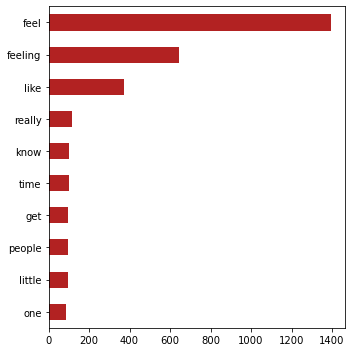

In [16]:
# Top 10 palabras (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(5, 5))
counts  = df_tidy['token'].value_counts(ascending=False).head(10)
counts.plot(kind='barh', color='firebrick')
axs.invert_yaxis()
fig.tight_layout()

### 3.3 Vectorización tf-idf

Empleando los mensajes se crea un matriz tf-idf en la que cada columna es un término, cada fila una publicación y el valor de intersección el tf-idf correspondiente. Esta matriz representa el espacio n-dimensional en el que se proyecta cada mensaje. Este transformación de los datos es necesaria para pasar la información a los algoritmos de clasificación

In [17]:
#Se extraen los valores "explicativos" y la variables objetivo
X = df['Mensaje']
y = df['Sentimiento']

In [18]:
# Creación de la matriz tf-idf que se usará más adelante
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words,
                        analyzer = "word"
                    )
X_vec = tfidf_vectorizador.fit_transform(X)
df_temp = pd.DataFrame(X_vec.toarray(), columns=tfidf_vectorizador.get_feature_names())
df_temp.sample(4)

,abandoned,able,absolutely,accept,acceptable,accepted,accepting,aching,act,action,...,yarn,year,years,yes,yesterday,yet,yoga,young,younger,youre
549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 1256
['abandoned', 'able', 'absolutely', 'accept', 'acceptable', 'accepted', 'accepting', 'aching', 'act', 'action']


### 3.4 Balanceo de datos

Finalmente, revisamos la distribución de los valores de nuestra variables objetivo "Sentimiento"

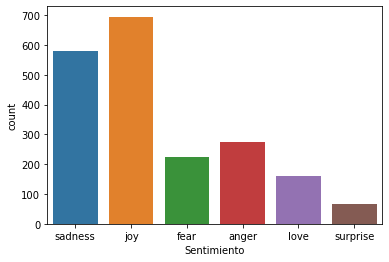

In [20]:
ax = sns.countplot(x='Sentimiento', data=df)

Como se puede ver, existe un desbalanceo notable. La mayoría de registros se concentran en las emociones "sadness" y "joy".

Intentaremos arreglar este problema de desbalanceo con la técnica de SMOTE

In [21]:
sm = SMOTE(random_state=0)
X_sm, y_sm = sm.fit_resample(X_vec,y)

Shape of X before SMOTE: (2000, 1256)
Hape of X after SMOTE: (4170, 1256)



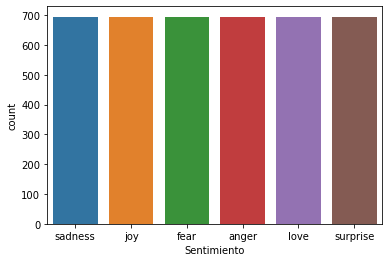

In [22]:
print(f'''Shape of X before SMOTE: {X_vec.shape}
Hape of X after SMOTE: {X_sm.shape}\n''')
ax = sns.countplot(x='Sentimiento', data=pd.DataFrame(y_sm, columns=['Sentimiento']))

## 4. Modelos de clasificación

Una vez terminado el preprocesamiento de los datos, procedemos a implementar diferentes modelos de clasificación que ayuden a conseguir el objetivo del negocio. Antes de comenzar, separaremos los datos en conjuntos de entrenamiento y prueba para los modelos.

In [23]:
df_metricas = pd.DataFrame([], columns = ["Modelo", "Params", "Accuracy", "Recall", "Precission", "F1 Score"])
X_train, X_test, y_train, y_test = train_test_split(
                                        X_sm,
                                        y_sm,
                                        test_size   = 0.2,
                                        random_state = 123
                                    )

In [24]:
#Unas funciones de utilidad
def print_metricas(modelo, X, y):
    y_pred = modelo.predict(X)
    print('Exactitud: %.2f' % accuracy_score(y, y_pred))
    print("Recall: {}".format(recall_score(y,y_pred, average="weighted")))
    print("Precisión: {}".format(precision_score(y,y_pred, average="weighted")))
    print("Puntuación F1: {}".format(f1_score(y,y_pred, average="weighted")))

def registrar_metricas(df, nombre_modelo, modelo, parametros, X, y):
    y_pred = modelo.predict(X)
    
    row = dict()
    row["Modelo"] = nombre_modelo
    row["Params"] = parametros
    row["Accuracy"] = accuracy_score(y, y_pred)
    row["Recall"] = recall_score(y, y_pred, average="weighted")
    row["Precission"] = precision_score(y, y_pred, average="weighted")
    row["F1 Score"] = f1_score(y, y_pred, average="weighted")
    
    return df.append(row, ignore_index=True)

### 4.1 Árbol de clasificación

#### Búsqueda de hiperparámetros

Se realiza una búsqueda con KFold y GridSearch para encontrar el mejor modelo

In [25]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,8,12,20],'min_samples_split':range(2,10)}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [26]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones, scoring="accuracy")
# Ajuste del modelo
_ = mejor_modelo.fit(X_train, y_train)

In [27]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
params = mejor_modelo.best_params_
params

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4}

#### Métricas

In [28]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
arbol_final = arbol_final.fit(X_train, y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [29]:
print_metricas(arbol_final, X_train, y_train)

Exactitud: 0.55
Recall: 0.5476618705035972
Precisión: 0.7892683462758686
Puntuación F1: 0.5106453870073444


Vemos el desempeño sobre el conjunto de prueba:

In [30]:
print_metricas(arbol_final, X_test, y_test)
df_metricas = registrar_metricas(df=df_metricas, nombre_modelo="Árbol de clasificación", modelo=arbol_final, parametros=params, X=X_test, y=y_test)

Exactitud: 0.51
Recall: 0.5095923261390888
Precisión: 0.5658104012197747
Puntuación F1: 0.4631029019065507


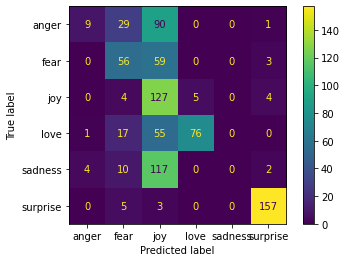

In [31]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol_final, X_test, y_test)  
plt.show()

En general observamos que no presenta unas métricas muy buenas.

### 4.2 Random Forest

#### Búsqueda de hiperparámetros

Se realiza una búsqueda con KFold y GridSearch para encontrar el mejor modelo

In [32]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,8,12,None],'min_samples_split':range(2,8)}
r_forest = RandomForestClassifier()

In [33]:
mejor_modelo = GridSearchCV(r_forest, param_grid, cv=particiones)
_ = mejor_modelo.fit(X_train, y_train)

In [34]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
params = mejor_modelo.best_params_
params

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4}

#### Métricas

In [35]:
# Obtener el mejor modelo.
rf_final = mejor_modelo.best_estimator_
rf_final = rf_final.fit(X_train,y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [36]:
print_metricas(rf_final, X_train, y_train)

Exactitud: 1.00
Recall: 0.999400479616307
Precisión: 0.9994026322927295
Puntuación F1: 0.9994007562419538


Vemos el desempeño sobre el conjunto de prueba:

In [37]:
print_metricas(rf_final, X_test, y_test)
df_metricas = registrar_metricas(df=df_metricas, nombre_modelo="Random Forest", modelo=rf_final, parametros=params, X=X_test, y=y_test)

Exactitud: 0.87
Recall: 0.8657074340527577
Precisión: 0.8769139897764142
Puntuación F1: 0.8642293155486366


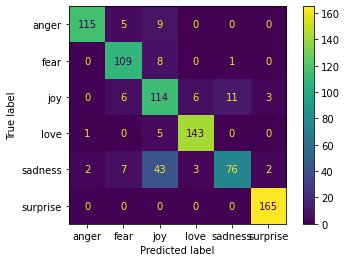

In [38]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(rf_final, X_test, y_test)  
plt.show()

Podemos observar que presenta unas métricas **bastante buenas** para ambos conjuntos.

### 4.3 Modelo SVM lineal

#### Búsqueda de hiperparámetros

Se realiza una búsqueda con KFold y GridSearch para encontrar el mejor modelo

In [39]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {'C': np.logspace(-5, 3, 10)}
modelo_svm = SVC(kernel= "linear", C = 1.0)

In [40]:
mejor_modelo = GridSearchCV(modelo_svm, param_grid, cv=particiones)
_ = mejor_modelo.fit(X_train, y_train)

In [41]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
params = mejor_modelo.best_params_
params

{'C': 2.154434690031882}

#### Métricas

In [42]:
# Obtener el mejor modelo.
svm_final = mejor_modelo.best_estimator_
svm_final = svm_final.fit(X_train,y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [43]:
print_metricas(svm_final, X_train, y_train)

Exactitud: 0.99
Recall: 0.9928057553956835
Precisión: 0.9928257003912934
Puntuación F1: 0.9927894928329292


Vemos el desempeño sobre el conjunto de prueba:

In [44]:
print_metricas(svm_final, X_test, y_test)
df_metricas = registrar_metricas(df=df_metricas, nombre_modelo="Modelo SVM", modelo=svm_final, parametros=params, X=X_test, y=y_test)

Exactitud: 0.93
Recall: 0.9316546762589928
Precisión: 0.9303623257835066
Puntuación F1: 0.9305370395511813


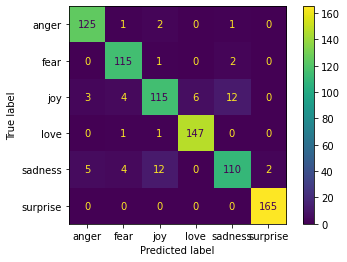

In [45]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(svm_final, X_test, y_test)  
plt.show()

Podemos observar que presenta unas métricas **bastante buenas** para ambos conjuntos.

### 4.4 KNearest-Neighbors

#### Búsqueda de hiperparámetros

Se realiza una búsqueda con KFold y GridSearch para encontrar el mejor modelo

In [46]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {"n_neighbors":list(range(1,10)), "p":[1,2]}
knn = KNeighborsClassifier()

In [47]:
mejor_modelo = GridSearchCV(knn, param_grid, cv=particiones)
_ = mejor_modelo.fit(X_train, y_train)

In [48]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
params = mejor_modelo.best_params_
params

{'n_neighbors': 1, 'p': 1}

#### Métricas

In [49]:
# Obtener el mejor modelo.
knn_final = mejor_modelo.best_estimator_
knn_final = knn_final.fit(X_train,y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [50]:
print_metricas(knn_final, X_train, y_train)

Exactitud: 1.00
Recall: 0.999400479616307
Precisión: 0.9994025504984613
Puntuación F1: 0.999400730563708


Vemos el desempeño sobre el conjunto de prueba:

In [51]:
print_metricas(knn_final, X_test, y_test)
df_metricas = registrar_metricas(df=df_metricas, nombre_modelo="K Nearest Neighbors", modelo=knn_final, parametros=params, X=X_test, y=y_test)

Exactitud: 0.88
Recall: 0.8776978417266187
Precisión: 0.8761156316647769
Puntuación F1: 0.8713134016565672


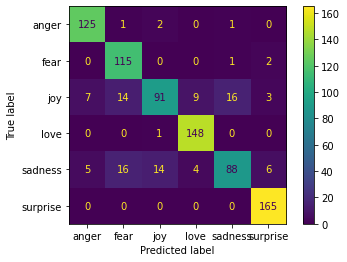

In [52]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(knn_final, X_test, y_test)  
plt.show()

Podemos observar que presenta unas métricas **buenas** para ambos conjuntos.

### 4.5 Naive Bayes

#### Búsqueda de hiperparámetros

Se realiza una búsqueda con KFold y GridSearch para encontrar el mejor modelo

In [53]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
param_grid = {"alpha":[0,1], "fit_prior":[True,False]}
naive_bayes = MultinomialNB()

In [54]:
mejor_modelo = GridSearchCV(naive_bayes, param_grid, cv=particiones)
_ = mejor_modelo.fit(X_train, y_train)

In [55]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
params = mejor_modelo.best_params_
params

{'alpha': 0, 'fit_prior': True}

#### Métricas

In [56]:
# Obtener el mejor modelo.
nb_final = mejor_modelo.best_estimator_
nb_final = nb_final.fit(X_train,y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [57]:
print_metricas(nb_final, X_train, y_train)

Exactitud: 0.98
Recall: 0.9796163069544365
Precisión: 0.9799282090440452
Puntuación F1: 0.9795829194794717


Vemos el desempeño sobre el conjunto de prueba:

In [58]:
print_metricas(nb_final, X_test, y_test)
df_metricas = registrar_metricas(df=df_metricas, nombre_modelo="Naive Baynes", modelo=nb_final, parametros=params, X=X_test, y=y_test)

Exactitud: 0.90
Recall: 0.8980815347721822
Precisión: 0.8952534435097056
Puntuación F1: 0.8951315506349566


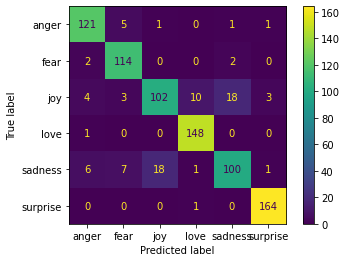

In [59]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(nb_final, X_test, y_test)  
plt.show()

Podemos observar que presenta unas métricas **buenas** para ambos conjuntos.

## 5. Resultados

Se revisan los resultados de todos los algoritmos

In [60]:
df_metricas

,Modelo,Params,Accuracy,Recall,Precission,F1 Score
0,Árbol de clasificación,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.509592,0.509592,0.565810,0.463103
1,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.865707,0.865707,0.876914,0.864229
2,Modelo SVM,{'C': 2.154434690031882},0.931655,0.931655,0.930362,0.930537
3,K Nearest Neighbors,"{'n_neighbors': 1, 'p': 1}",0.877698,0.877698,0.876116,0.871313
4,Naive Baynes,"{'alpha': 0, 'fit_prior': True}",0.898082,0.898082,0.895253,0.895132


En general todos los modelos a excpeción del árbol tienen un buen desempeño. Las métricas sobre los conjuntos de prueba indican que los modelos no se encuentran sobreajustados y por lo tanto están en capacidad de generalizar.

Analizando individualmente cada métrica podemos ver lo siguiente:

* **Accuracy:** el modelo con una mayor precisión es el modelo SVM. Esto significa que es el que mejor capacitado para predecir y acertar los registros que corresponden y no a cierto sentimiento.
* **Recall:** el modelo con una mayor sensibilidad es el modelo SVM. Esto significa que es el que predice con la menor cantidad de valores falsos negativos.
* **Precission:** el modelo con una mayor precisión es el modelo SVM. Esto significa que es el que predice con la menor cantidad de valores falsos negativos.
* **F1 Score:** el modelo con una mayor precisión es el modelo SVM. 


En vista de lo anterior, resulta bastante evidente concluir que el mejor modelo es el modelo SVM. Este modelo podría ser utilizado por un negocio para conocer la opinión que puedan tener los usuarios de las redes sociales sobre algunos productos o campañas de marketing que se han realizado. El conocer la perspectiva de las personas puede suponer una ventaja comercial para el negocio con respecto al mercado.

## Bibliografía

Este Notebook fue desarrollado utilizando las librerías de sklearn, pd, matplotlib, nltk nmencionadas en el punto 1. y siguiendo un artículo de ejemplo de analítica de textos con machine learning disponible en [este enlace](https://www.cienciadedatos.net/documentos/py25-text-mining-python.html).




**Inteligencia de Negocios - ISIS 3301**